In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import correlate2d
from sklearn.metrics import confusion_matrix

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Circle

In [3]:
from bayesee.generation import *

In [4]:
%load_ext autoreload
%autoreload 2
plt.style.use('bayesee.academic')

In [5]:
repo_path = Path.cwd().parents[0]
print(repo_path)

c:\Users\aqfra\Documents\GitRepo\bayesee


In [6]:
subject = "AZ_t2"
file_name = repo_path / f"data/covert-search/large-field/derived/est_dp_{subject}.npy"
local_dp = np.load(file_name)
indexes_near = np.array([1, 2, 9, 10, 11, 14, 15])
local_dp = local_dp[indexes_near - 1]
print(local_dp)

[3.85921359 2.33516598 4.7879596  2.07819318 3.85921359 3.11074147
 3.06846955]


In [7]:
file_name = repo_path / f"data/covert-search/large-field/p4_data_{subject}.mat"
data = loadmat(file_name)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'backgroundStd', 'bgContrast', 'bgMean', 'clipTolerance', 'conditionLabels', 'cueOff', 'expCompleted', 'fieldRatio', 'hResponse', 'locations', 'matlabvers', 'monitorBit', 'monitorGamma', 'monitorPx', 'nConditions', 'nDirections', 'nLevels', 'nLocations', 'nSessions', 'nTrials', 'ppd', 'reactionTime', 'responseWait', 'sceneLength', 'sessionLabels', 'spotCenters', 'spotDistance', 'spotLength', 'spotResize', 'stimOff', 'stimOn', 'subject', 'tLocation', 'targetAmplitude', 'targetLength', 'targets', 'title', 'totalLength'])


In [8]:
target_amplitude = data["targetAmplitude"]
spot_center = data["spotCenters"][indexes_near - 1, :]
n_location = len(indexes_near) + 1
spot_diameter = data["spotLength"][0][0]
stimulus_design_size = data["totalLength"][0][0]
monitor_width = data["monitorPx"][0][0]
monitor_height = data["monitorPx"][0][1]
ppd = data["ppd"][0][0]
target = data["targets"]
background_mean = data["bgMean"][0][0]
background_std = data["bgContrast"][0][0] * background_mean

In [9]:
shifted_spot_center = spot_center.copy()
shifted_spot_center[:, 0] += (monitor_height - stimulus_design_size) // 2
shifted_spot_center[:, 1] += (monitor_width - stimulus_design_size) // 2

In [10]:
print(
    f"N Location:{n_location-1}\nTarget Size:{target.shape}\nBackground Mean:{background_mean}\nBackground STD:{background_std}"
)

N Location:7
Target Size:(30, 30)
Background Mean:128
Background STD:25.6


In [11]:
prior = np.array((0.5, *((0.5 / (n_location - 1),) * (n_location - 1))))
assert np.allclose(prior.sum(), 1.0)
log_prior_ratio = np.log(prior / prior[0])
log_likelihood_ratio = np.zeros_like(prior)

In [12]:
n_trials = 800
the_target_amplitude = target_amplitude[0, 0, 0]

target_location = np.zeros((n_trials,), dtype=np.int64)
target_location[: n_trials // 2] = np.random.randint(1, n_location, size=n_trials // 2)
model_response = np.zeros_like(target_location)

assert np.allclose(np.dot(target.flatten(), target.flatten()), 1.0)

for index_trial in range(n_trials):
    array_standard_normal = np.random.normal(size=(n_location - 1,))
    log_likelihood_ratio[1:] = array_standard_normal * local_dp - local_dp**2 / 2
    if target_location[index_trial] > 0:
        log_likelihood_ratio[target_location[index_trial]] += (
            local_dp[target_location[index_trial] - 1] ** 2
        )

    log_posterior_ratio = log_prior_ratio + log_likelihood_ratio
    model_response[index_trial] = np.argmax(log_posterior_ratio)

In [13]:
accurate_response = target_location == model_response

In [14]:
spatial_statistics = pd.DataFrame({"id": range(1, n_location)})

In [15]:
list_spot_region = [np.zeros(monitor_width, monitor_height)] * (n_location - 1)
pixel_col, pixel_row = np.meshgrid(np.arange(monitor_width), np.arange(monitor_height))

for index_location in range(n_location - 1):
    list_spot_region[index_location] = (
        pixel_row - shifted_spot_center[index_location, 0]
    ) ** 2 + (
        pixel_col - shifted_spot_center[index_location, 1]
    ) ** 2 <= spot_diameter**2 / 4

In [16]:
stimulus_region = np.zeros((monitor_height, monitor_width))

for index_location in range(n_location - 1):
    stimulus_region[list_spot_region[index_location]] = 1

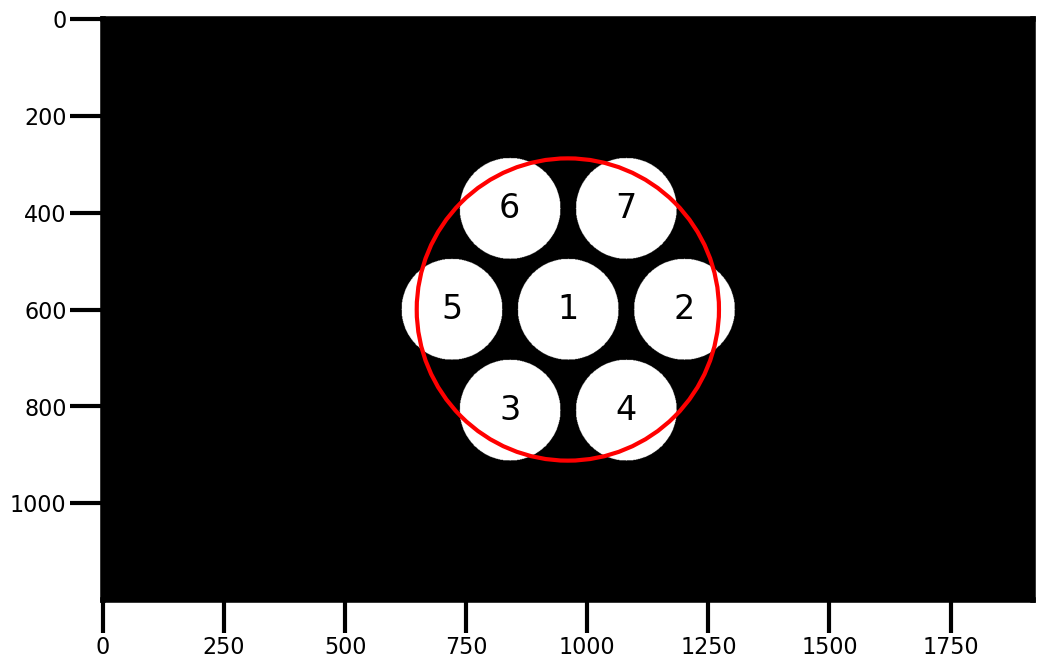

In [17]:
fig, ax = plt.subplots()
ax.imshow(stimulus_region)

for index_location in range(n_location - 1):
    ax.text(
        shifted_spot_center[index_location, 1],
        shifted_spot_center[index_location, 0],
        f"{index_location+1}",
        ha="center",
        va="center",
    )

circle = Circle(
    (monitor_width // 2, monitor_height // 2),
    spot_diameter * 1.5,
    edgecolor="r",
    facecolor="none",
    linewidth=3,
)
ax.add_patch(circle)

In [18]:
array_eccentral_distance = np.zeros((n_location - 1,))

for index_location in range(n_location - 1):
    array_eccentral_distance[index_location] = np.sqrt(
        (spot_center[index_location, 0] - stimulus_design_size // 2) ** 2
        + (spot_center[index_location, 1] - stimulus_design_size // 2) ** 2
    )

array_eccentral_distance /= ppd

print(array_eccentral_distance)

[0.         4.         4.00222161 4.00222161 4.         4.00222161
 4.00222161]


In [19]:
pixel_precision_array_eccentral_distance = array_eccentral_distance.copy()

for index_d1, distance1 in enumerate(np.unique(array_eccentral_distance)):
    for index_d2, distance2 in enumerate(
        np.unique(array_eccentral_distance)[index_d1 + 1 :]
    ):
        if distance1 != distance2 and np.abs(distance2 - distance1) < 0.5:
            print(index_d1, distance1, index_d2, distance2)
            pixel_precision_array_eccentral_distance[
                array_eccentral_distance == distance2
            ] = distance1

print(pixel_precision_array_eccentral_distance)

1 4.0 0 4.002221605280969
[0. 4. 4. 4. 4. 4. 4.]


In [20]:
spatial_statistics["ecc"] = pixel_precision_array_eccentral_distance.round(3)

In [21]:
eccentral_distance_sorted_indexes = np.argsort(
    pixel_precision_array_eccentral_distance, kind="stable"
)
extra_eccentral_distance_sorted_indexes = np.insert(
    eccentral_distance_sorted_indexes + 1, 0, 0
)
print(extra_eccentral_distance_sorted_indexes)

[0 1 2 3 4 5 6 7]


In [22]:
indexes_near = np.arange(1, n_location)[
    pixel_precision_array_eccentral_distance < spot_diameter * 1.5 / ppd
]
indexes_far = np.arange(1, n_location)[
    pixel_precision_array_eccentral_distance > spot_diameter * 1.5 / ppd
]
print(indexes_near, indexes_far)

[1 2 3 4 5 6 7] []


In [23]:
accuracy_all = accurate_response.mean()
accuracy_near = accurate_response[np.isin(target_location, indexes_near)].mean()
print(accuracy_all, accuracy_near)

0.84125 0.78


In [24]:
confusion_mat = confusion_matrix(
    model_response.flatten(), target_location.flatten(), labels=range(n_location)
)
sorted_confusion_mat = confusion_mat[extra_eccentral_distance_sorted_indexes, :][
    :, extra_eccentral_distance_sorted_indexes
]
array_index_location = np.arange(n_location)[extra_eccentral_distance_sorted_indexes]

In [25]:
correct_rejection = sorted_confusion_mat[0][0]
second_largest_confusion_mat = np.max(
    np.delete(sorted_confusion_mat, np.where(sorted_confusion_mat == correct_rejection))
)
plotted_sorted_confusion_mat = sorted_confusion_mat.copy()
plotted_sorted_confusion_mat[0][0] = second_largest_confusion_mat
print(second_largest_confusion_mat)

56


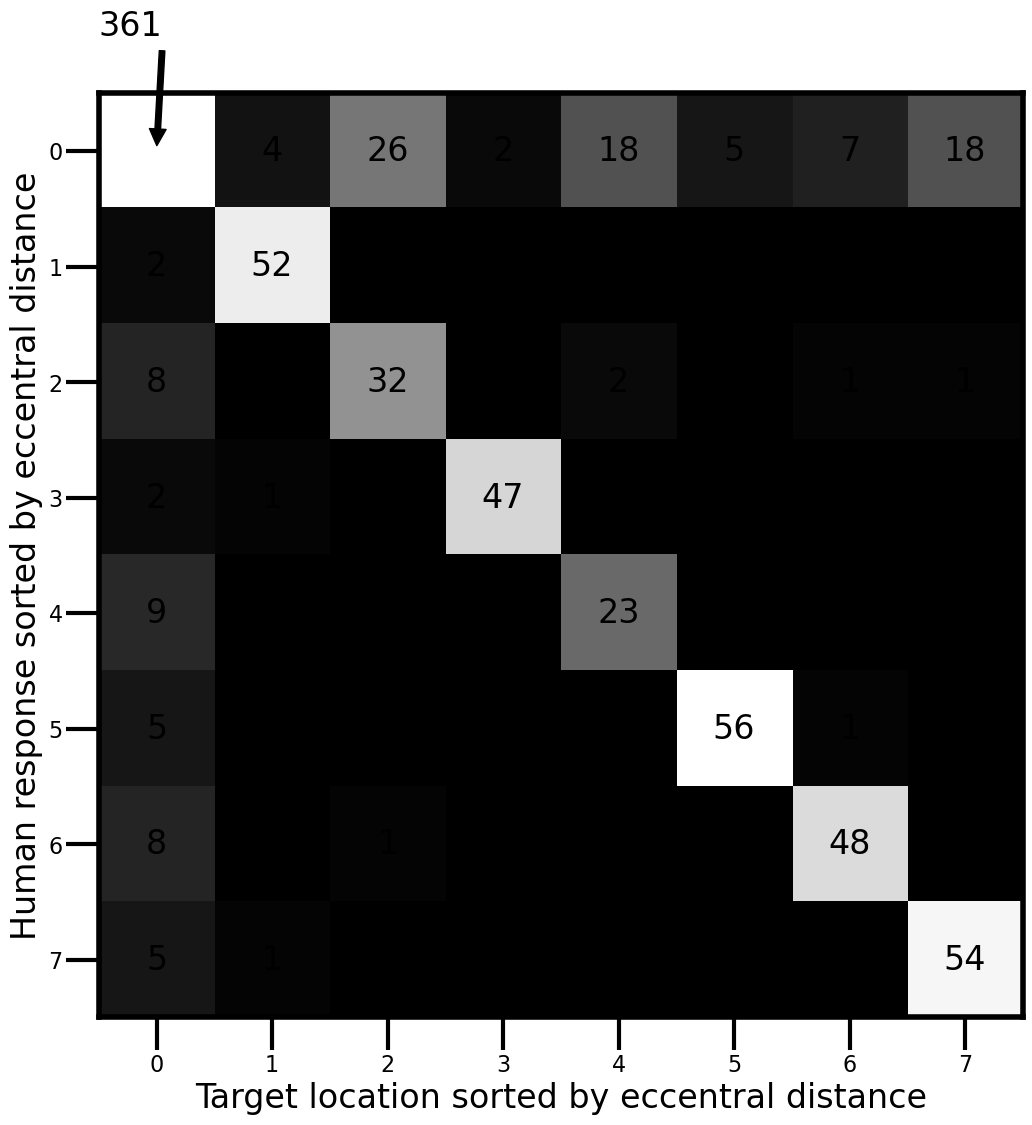

In [26]:
fig, ax = plt.subplots(figsize=(15, 12))
im = ax.imshow(plotted_sorted_confusion_mat)

for index_target_location in array_index_location:
    for index_model_response in array_index_location:
        if not (-index_target_location == 0 and index_model_response == 0):
            ax.text(
                index_model_response,
                index_target_location,
                f"{sorted_confusion_mat[index_target_location, index_model_response]:.0f}",
                ha="center",
                va="center",
            )

ax.annotate(
    f"{correct_rejection:.0f}",
    xy=(0, 0),
    xytext=(-0.5, -1),
    arrowprops=dict(facecolor="black", shrink=0.05),
)

ax.set(
    xticks=np.arange(n_location),
    yticks=np.arange(n_location),
    xticklabels=array_index_location,
    yticklabels=array_index_location,
    xlabel="Target location sorted by eccentral distance",
    ylabel="Human response sorted by eccentral distance",
)

plt.show()

In [27]:
local_hit_rate = np.array(
    [
        confusion_mat[index_location + 1, index_location + 1]
        / confusion_mat[:, index_location + 1].sum()
        for index_location in range(n_location - 1)
    ]
)

local_miss_rate = np.array(
    [
        confusion_mat[0, index_location + 1]
        / confusion_mat[:, index_location + 1].sum()
        for index_location in range(n_location - 1)
    ]
)

local_fa_rate = np.array(
    [
        confusion_mat[index_location + 1, 0] / confusion_mat[:, 0].sum()
        for index_location in range(n_location - 1)
    ]
)

cr = (confusion_mat[0, 0]).sum() / confusion_mat[:, 0].sum()

In [28]:
spatial_statistics["hit_rate"] = local_hit_rate
spatial_statistics["miss_rate"] = local_miss_rate
spatial_statistics["fa_rate"] = local_fa_rate

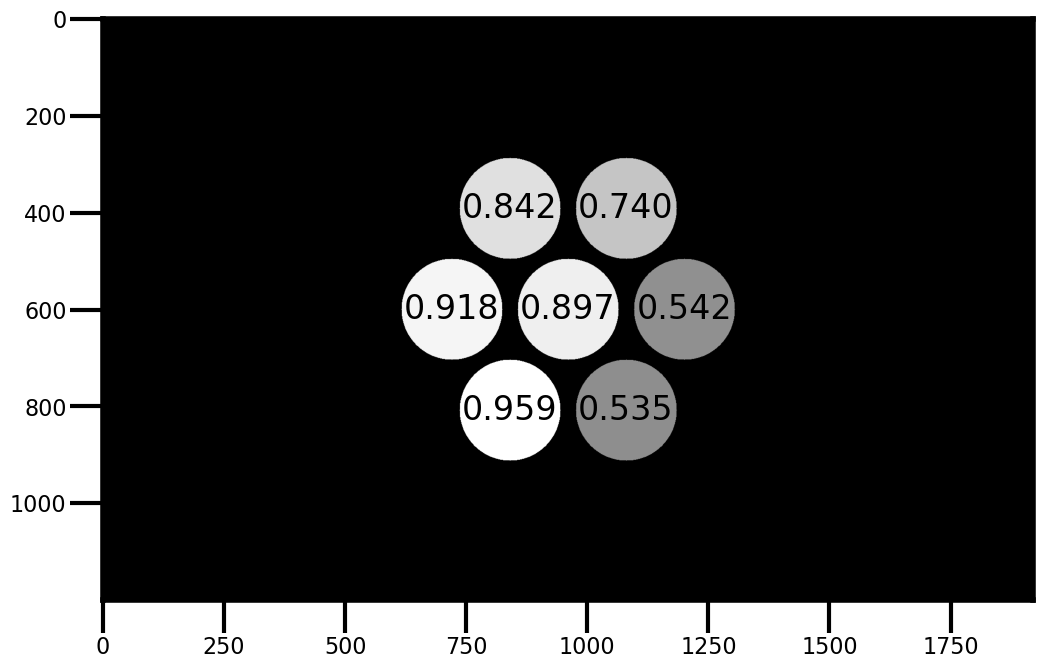

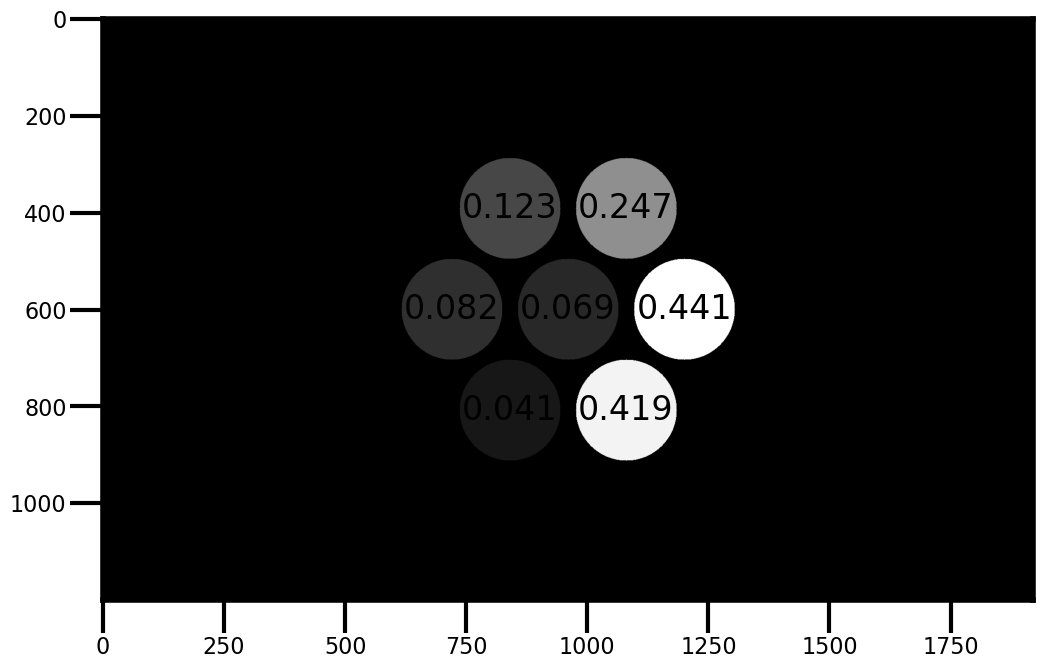

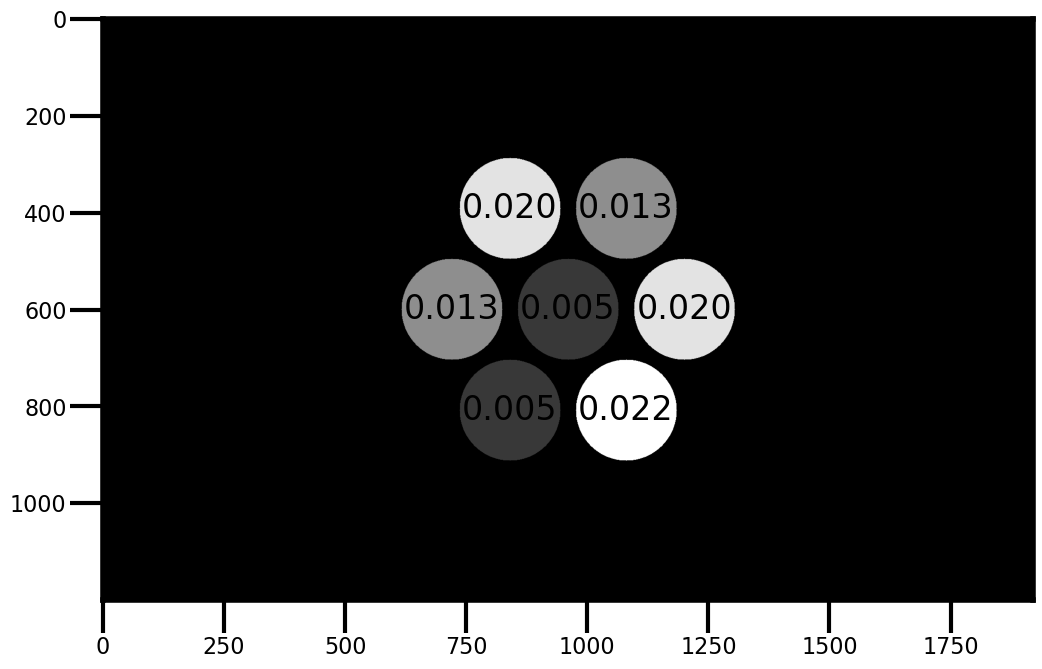

Correct Rejection:0.9025


In [29]:
for statistic in [local_hit_rate, local_miss_rate, local_fa_rate]:
    statistic_region = np.empty((monitor_height, monitor_width))
    for index_location in range(n_location - 1):
        statistic_region[list_spot_region[index_location]] = statistic[index_location]

    fig, ax = plt.subplots()
    ax.imshow(statistic_region)

    for index_location in range(n_location - 1):
        ax.text(
            shifted_spot_center[index_location, 1],
            shifted_spot_center[index_location, 0],
            f"{statistic[index_location]:.3f}",
            ha="center",
            va="center",
        )

    plt.show()

print(f"Correct Rejection:{cr}")

In [30]:
local_present_count = np.array(
    [
        confusion_mat[:, index_location + 1].sum()
        for index_location in range(n_location - 1)
    ]
)

local_hit_count = np.array(
    [
        confusion_mat[index_location + 1, index_location + 1]
        for index_location in range(n_location - 1)
    ]
)

local_miss_count = np.array(
    [confusion_mat[0, index_location + 1] for index_location in range(n_location - 1)]
)

local_fa_count = np.array(
    [confusion_mat[index_location + 1, 0] for index_location in range(n_location - 1)]
)

local_fh_from_count = np.array(
    [
        confusion_mat[1:, index_location + 1].sum()
        - confusion_mat[index_location + 1, index_location + 1]
        for index_location in range(n_location - 1)
    ]
)

local_fh_to_count = np.array(
    [
        confusion_mat[index_location + 1, 1:].sum()
        - confusion_mat[index_location + 1, index_location + 1]
        for index_location in range(n_location - 1)
    ]
)

In [31]:
spatial_statistics["present_count"] = local_present_count
spatial_statistics["hit_count"] = local_hit_count
spatial_statistics["miss_count"] = local_miss_count
spatial_statistics["fa_count"] = local_fa_count
spatial_statistics["fh_from_count"] = local_fh_from_count
spatial_statistics["fh_to_count"] = local_fh_to_count

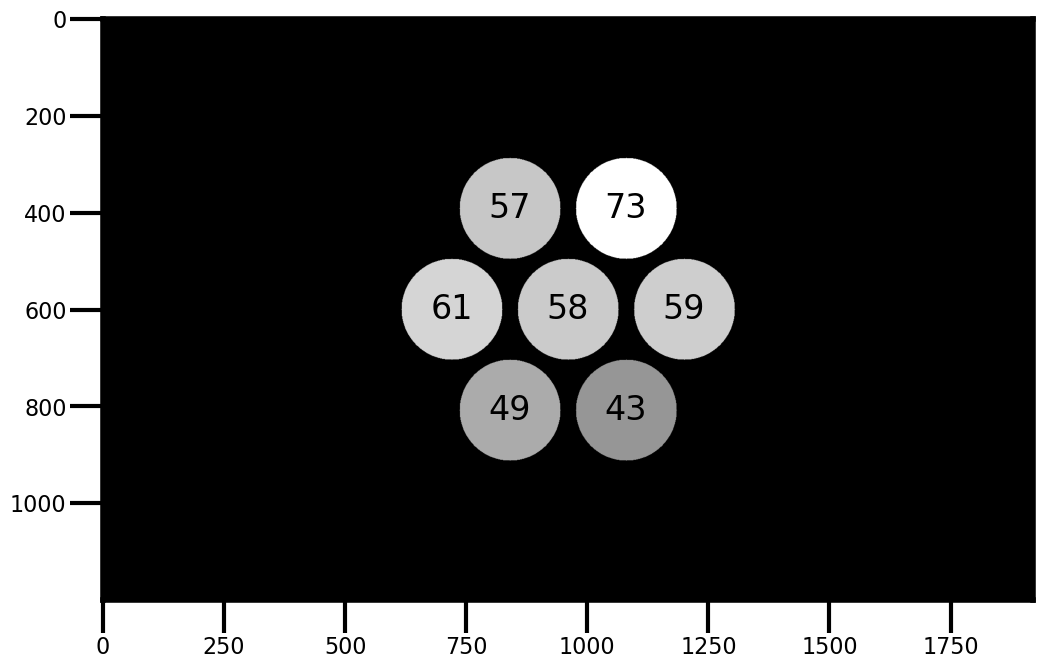

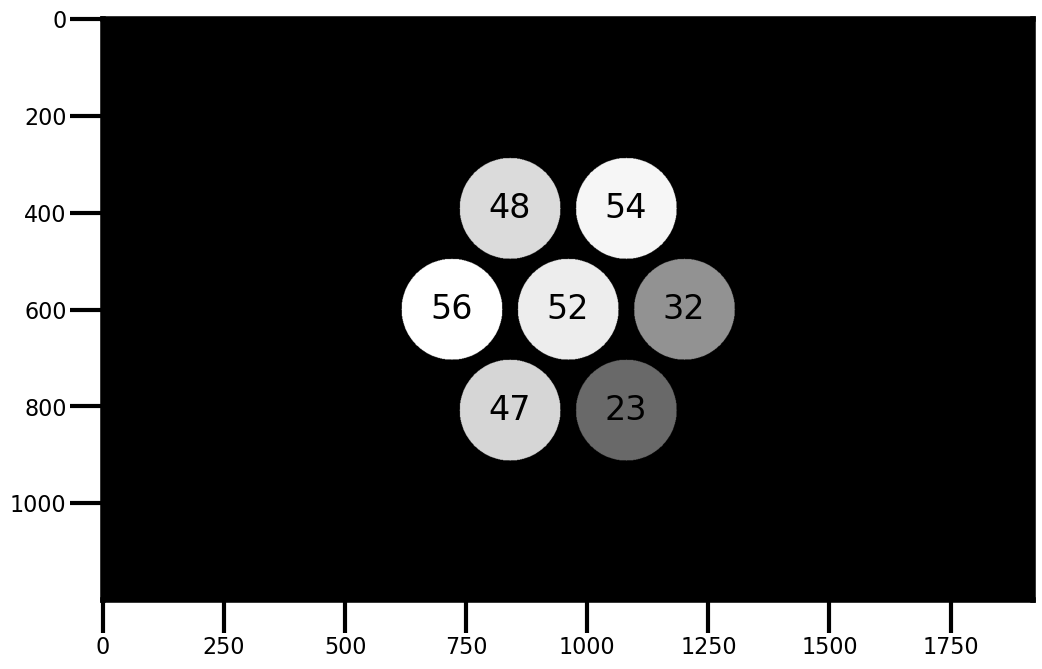

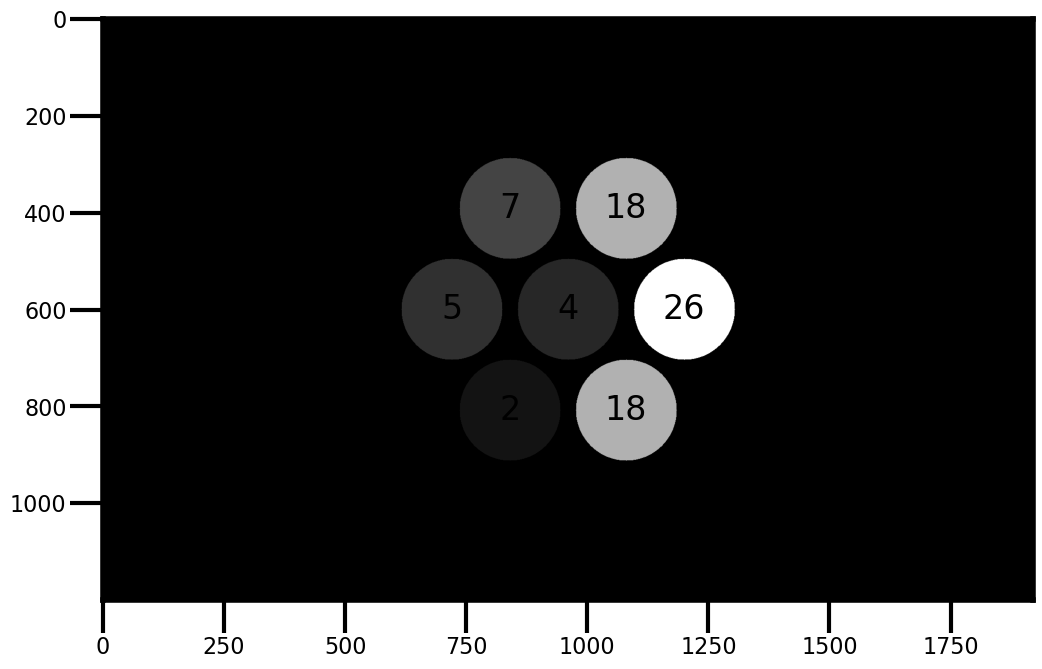

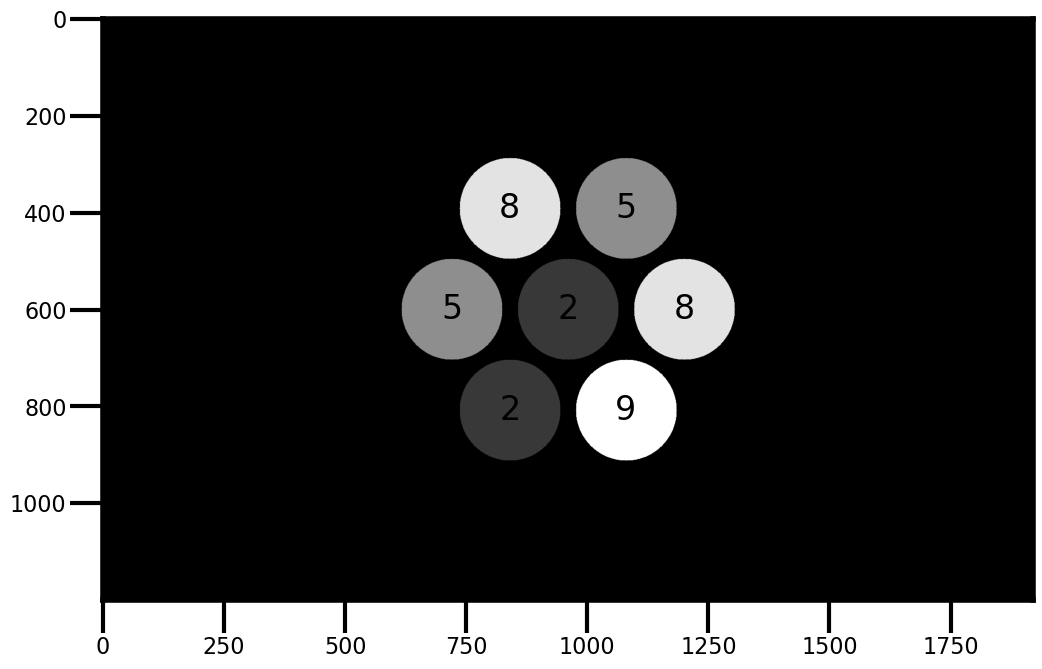

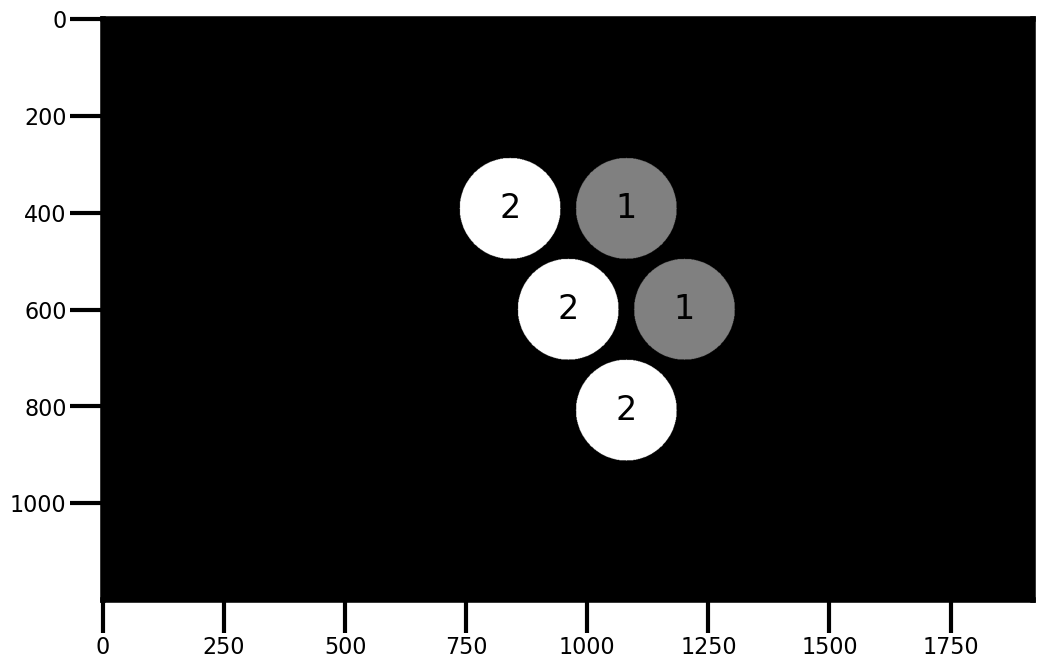

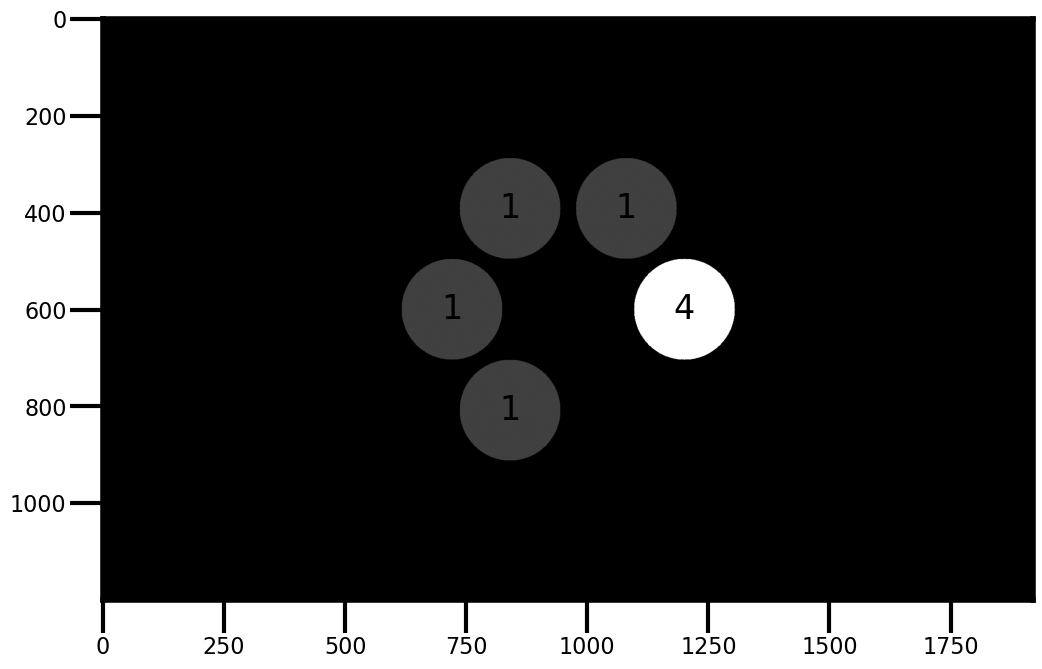

In [32]:
for count in [
    local_present_count,
    local_hit_count,
    local_miss_count,
    local_fa_count,
    local_fh_from_count,
    local_fh_to_count,
]:
    count_region = np.empty((monitor_height, monitor_width))
    for index_location in range(n_location - 1):
        count_region[list_spot_region[index_location]] = count[index_location]

    fig, ax = plt.subplots()
    ax.imshow(count_region)

    for index_location in range(n_location - 1):
        ax.text(
            shifted_spot_center[index_location, 1],
            shifted_spot_center[index_location, 0],
            f"{count[index_location]:.0f}",
            ha="center",
            va="center",
        )

    plt.show()

In [33]:
array_orientation = np.ones((n_location - 1,)) * -1

for index_location in range(1, n_location - 1):
    dy = spot_center[index_location, 0] - stimulus_design_size // 2
    dx = stimulus_design_size // 2 - spot_center[index_location, 1]
    array_orientation[index_location] = (1 - np.arctan2(dy, dx) / np.pi) / 2

print(array_orientation)

[-1.          0.          0.33328233  0.16671767  0.5         0.66671767
  0.83328233]


In [34]:
spatial_statistics["orientation"] = array_orientation.round(3)

In [35]:
orientation_hsv_color_map = np.zeros((n_location - 1, 3))
orientation_hsv_color_map[:, 0] = array_orientation

for index_location in range(n_location - 1):
    orientation_hsv_color_map[index_location, 1] = 1

    if index_location == 0:
        orientation_hsv_color_map[index_location, 2] = 0
    else:
        orientation_hsv_color_map[index_location, 2] = 0.75

rgb_orientation_color_map = hsv_to_rgb(orientation_hsv_color_map)

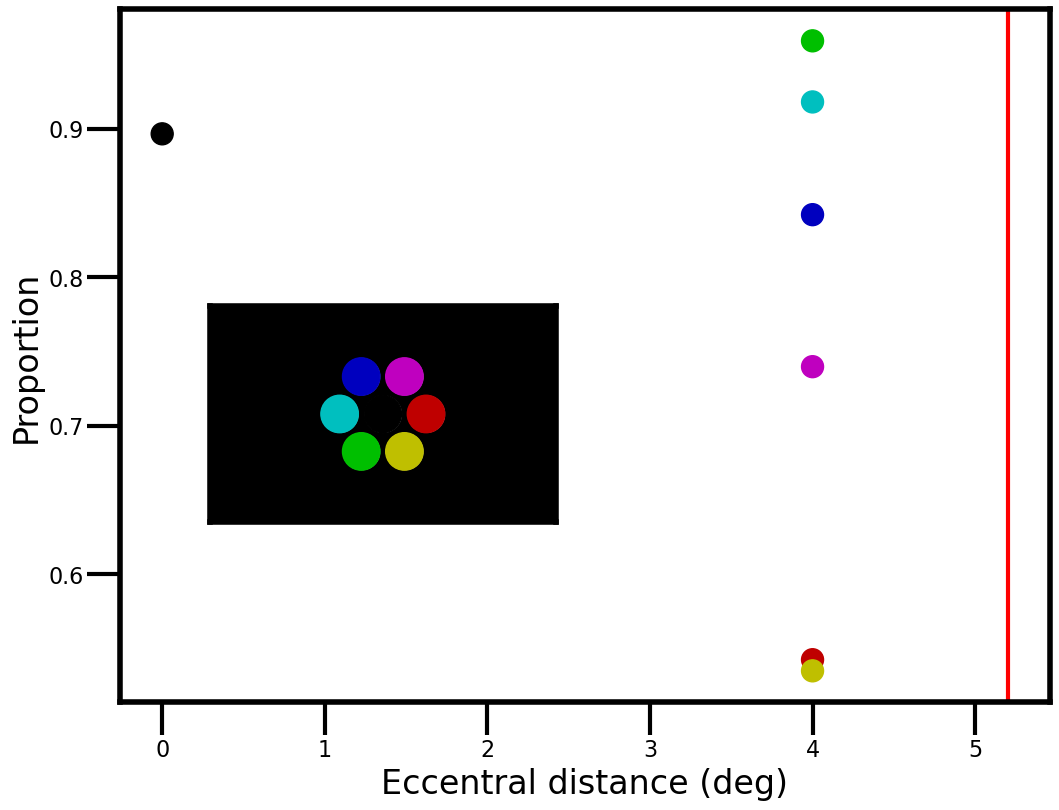

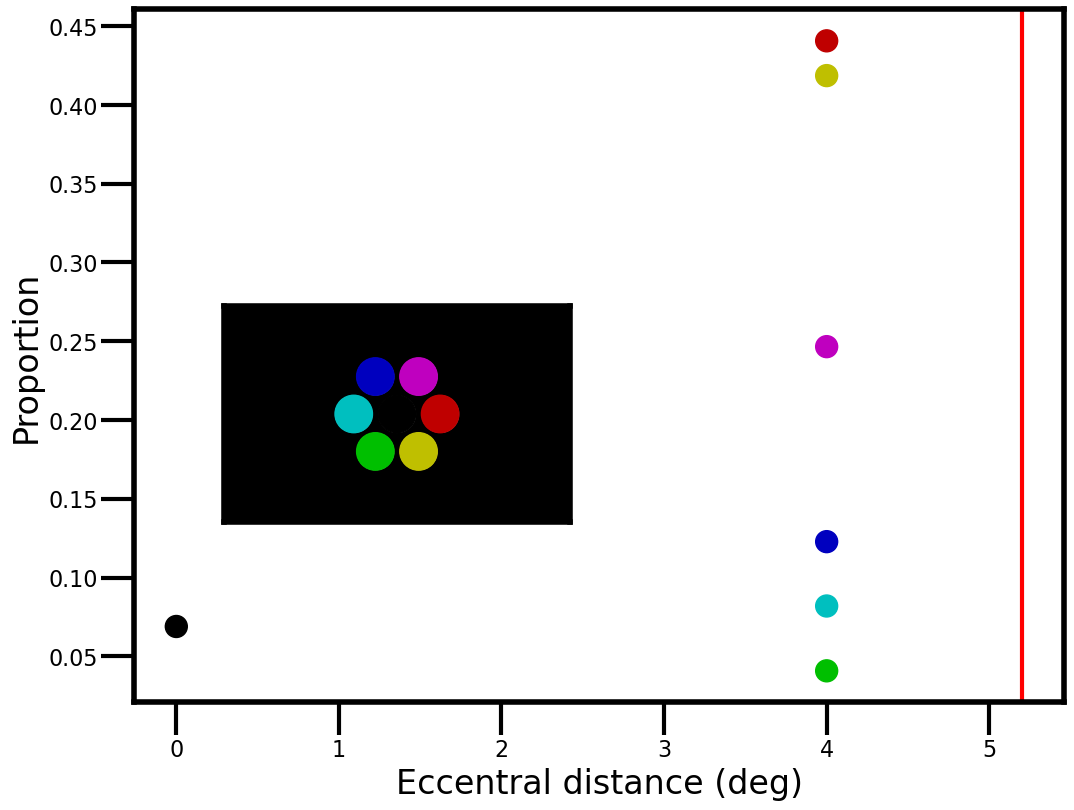

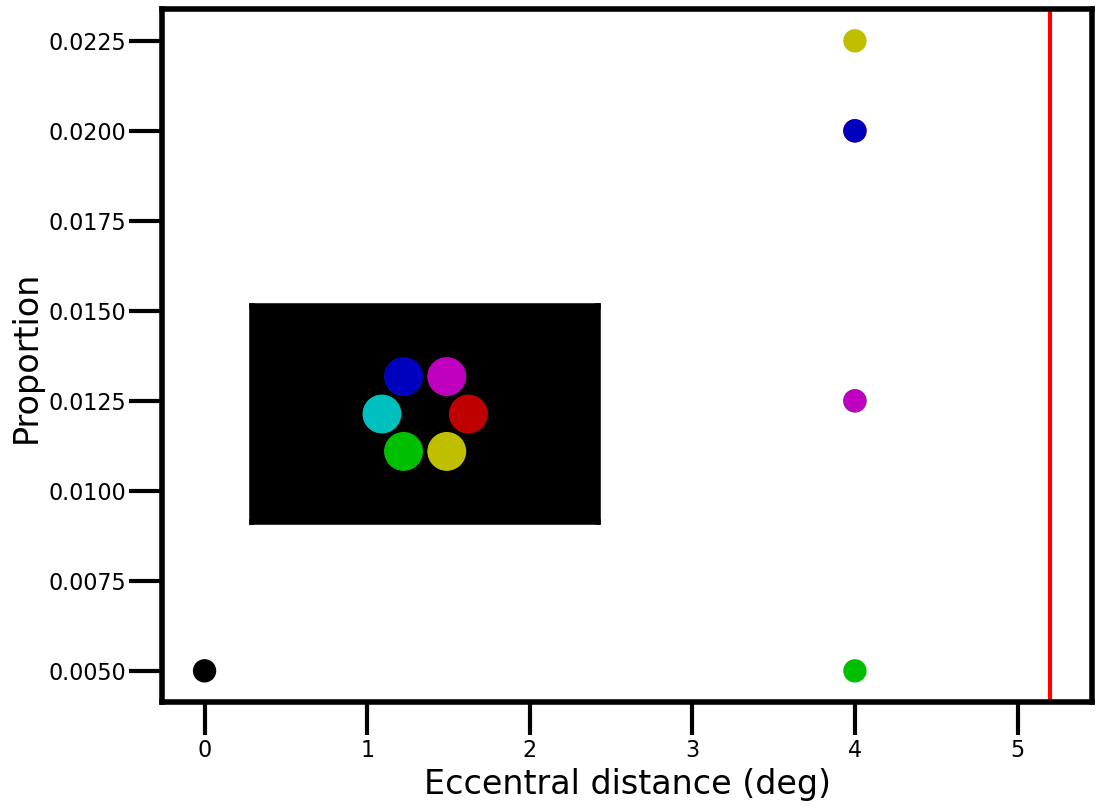

In [36]:
for statistic in [local_hit_rate, local_miss_rate, local_fa_rate]:
    fig, ax = plt.subplots()
    ax.scatter(
        pixel_precision_array_eccentral_distance,
        statistic,
        s=250,
        c=rgb_orientation_color_map,
    )

    ax.set(xlabel="Eccentral distance (deg)", ylabel="Proportion")
    ax.axvline(x=spot_diameter * 1.5 / ppd, color="r", linewidth=3)

    inner_ax = fig.add_axes([0.2, 0.2, 0.288, 0.461])
    inner_ax.imshow(stimulus_region)
    inner_ax.set(xticks=[], yticks=[])

    for index_location in range(n_location - 1):
        circle = Circle(
            (
                shifted_spot_center[index_location, 1],
                shifted_spot_center[index_location, 0],
            ),
            spot_diameter / 2,
            color=rgb_orientation_color_map[index_location],
            linewidth=1,
        )
        inner_ax.add_patch(circle)

    plt.show()

In [37]:
orientation_color_palette = dict(
    zip(spatial_statistics["orientation"], rgb_orientation_color_map)
)

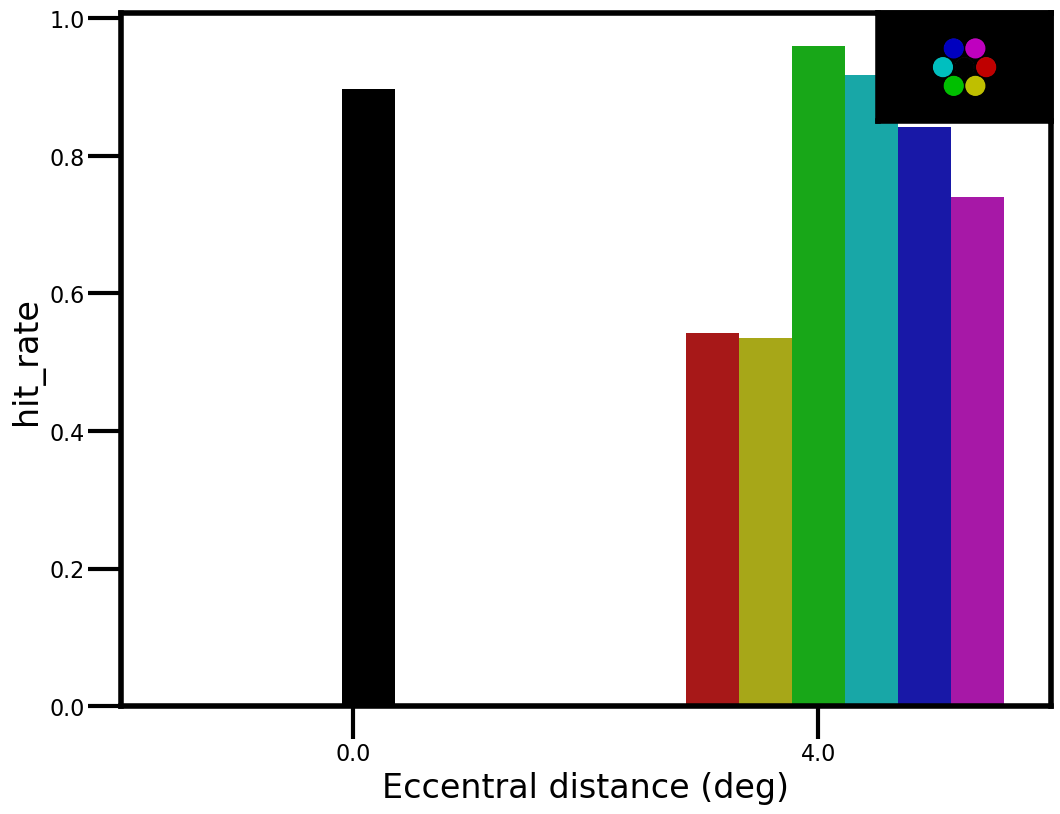

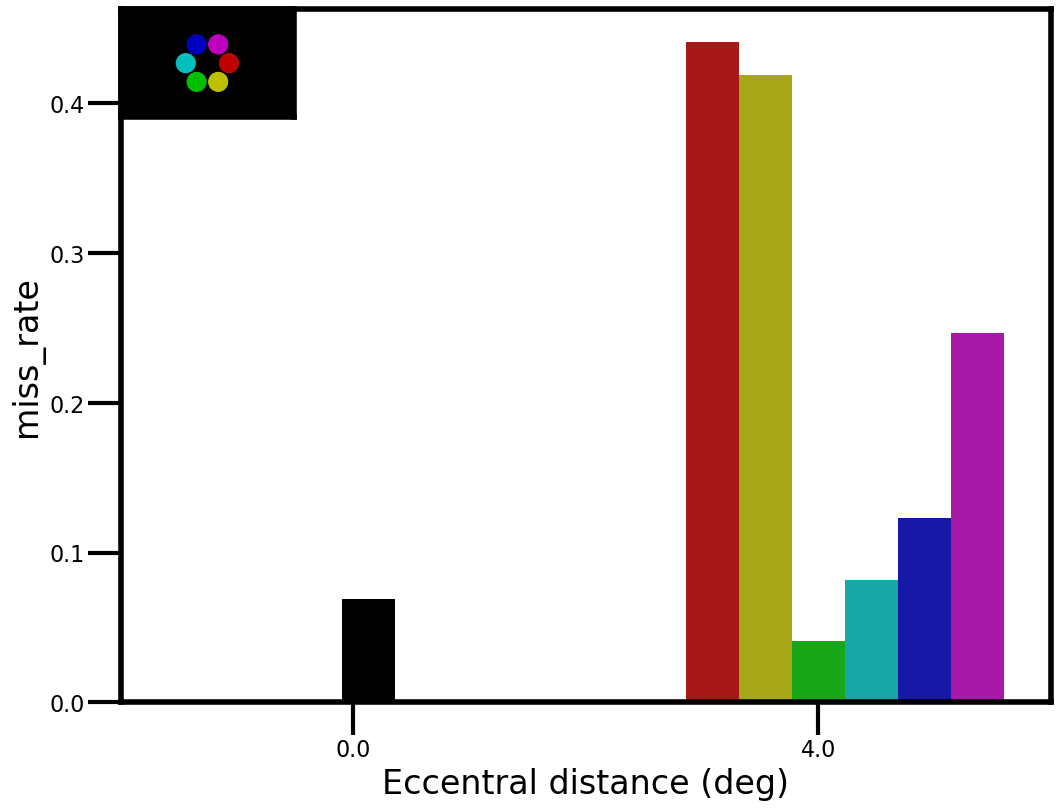

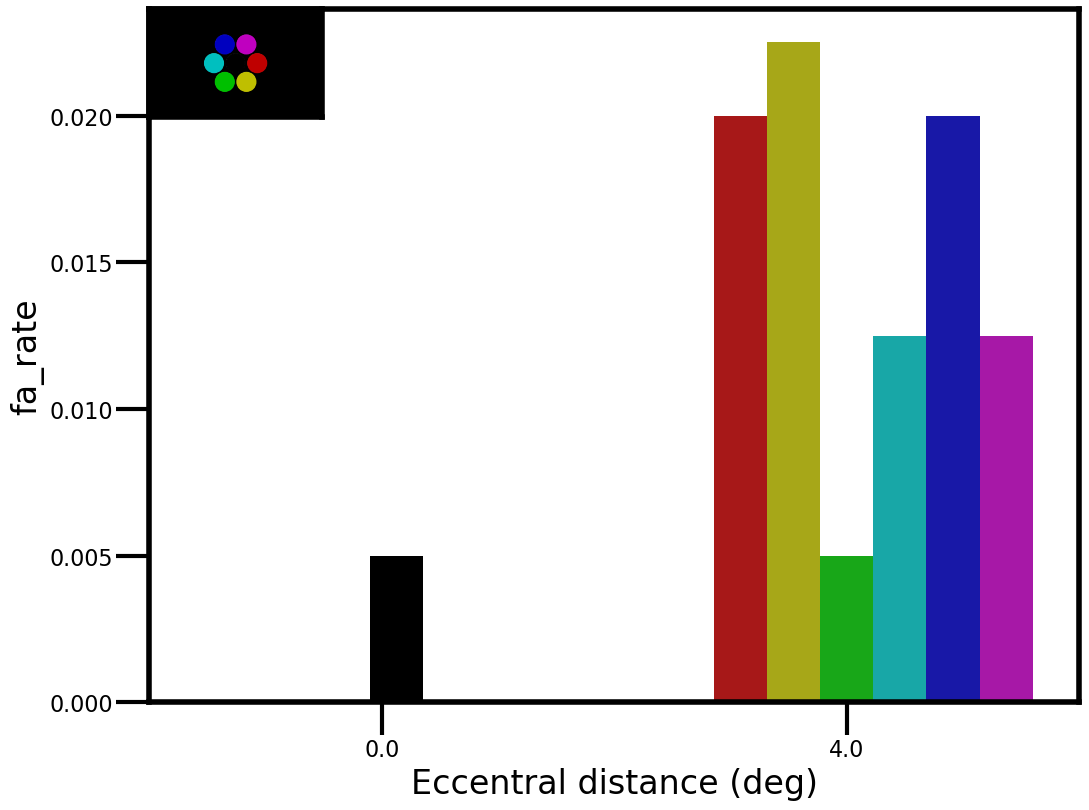

In [38]:
for statistic in ["hit_rate", "miss_rate", "fa_rate"]:
    fig, ax = plt.subplots()
    sns.barplot(
        data=spatial_statistics,
        x="ecc",
        y=statistic,
        hue="orientation",
        palette=orientation_color_palette,
        ax=ax,
    )
    ax.legend_.remove()
    ax.set(xlabel="Eccentral distance (deg)")

    for i, patch in enumerate(ax.patches):
        if i == 0:
            patch.set_x(patch.get_x() + 0.375)

    if statistic == "hit_rate":
        inner_ax = fig.add_axes([0.756, 0.7, 0.144, 0.2405])
    else:
        inner_ax = fig.add_axes([0.125, 0.7, 0.144, 0.2405])

    inner_ax.imshow(stimulus_region)
    inner_ax.set(xticks=[], yticks=[])

    for index_location in range(n_location - 1):
        circle = Circle(
            (
                shifted_spot_center[index_location, 1],
                shifted_spot_center[index_location, 0],
            ),
            spot_diameter / 2,
            color=rgb_orientation_color_map[index_location],
            linewidth=1,
        )
        inner_ax.add_patch(circle)

    plt.show()

In [39]:
spatial_statistics.to_csv(
    repo_path
    / f"data/covert-search/large-field/derived/p4_spatial_statistics_baseline_model.csv",
    index=False,
)